# A/B TESTING ANALYSIS

# Contents:

* About the Data Set
* Import Libraries 
* Outlier
* A/B Testing

# About the Data Set 
As players progress through the levels of the game, they'll encounter gates that require time-based waiting or in-app purchases. Beyond driving purchases, these gates provide essential breaks, aiming to enhance and prolong the player's overall enjoyment

But where should the gates be placed? Initially the first gate was placed at level 30. In this project, we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40.

you can click here to watch the short demo 

https://www.youtube.com/watch?v=GaP5f0jVTWE

The data is from 90,189 players that installed the game while the AB-test was running. The variables are:

* userid - a unique number that identifies each player.
* version - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
* sum_gamerounds - the number of game rounds played by the player during the first week after installation
* retention_1 - did the player come back and play 1 day after installing?
* retention_7 - did the player come back and play 7 days after installing?

When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

# Import Libraries

In [7]:
!pip install scikit-learn



     -------------------------------------- 11.2/11.2 MB 813.6 kB/s eta 0:00:00
     ------------------------------------ 307.7/307.7 KB 793.2 kB/s eta 0:00:00


You should consider upgrading via the 'C:\Users\Ahmet\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [8]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal
from statsmodels.stats.proportion import proportions_ztest
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [9]:
df=pd.read_csv(r"C:\Users\Ahmet\Desktop\cookie_cats.csv")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [10]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### info #####################")
    print(dataframe.info())

check_df(df)

##################### Shape #####################
(90189, 5)
##################### Types #####################
userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object
##################### NA #####################
userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64
##################### info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
None


In [11]:
df["userid"].nunique() # There is no multiplexing of players.

90189

In [12]:
df.groupby("version").agg({"sum_gamerounds":["count","sum","mean","min","max"]})

sum_gamerounds                            
                 count      sum    mean min    max
version                                           
gate_30          44700  2344795 52.4563   0  49854
gate_40          45489  2333530 51.2988   0   2640

it seems gate_30 and gate_40 has the similar values but lets continue to understand the data

In [13]:
df.groupby("version").agg({"version":"count",
                           "retention_1":["sum","mean"],
                           "retention_7":["sum","mean"]})

# When we examine the average and total values of people who played after 1 day and within 7 days, we still see similar rates.

version retention_1        retention_7       
          count         sum   mean         sum   mean
version                                              
gate_30   44700       20034 0.4482        8502 0.1902
gate_40   45489       20119 0.4423        8279 0.1820

In [14]:
df.groupby(["version","retention_1","retention_7"]).agg({"sum_gamerounds":["sum","mean"]})

sum_gamerounds         
                                           sum     mean
version retention_1 retention_7                        
gate_30 False       False               269963  11.8197
                    True                183388 100.4315
        True        False               663819  49.6945
                    True               1227625 183.8863
gate_40 False       False               281118  11.9133
                    True                133438  75.2611
        True        False               680997  50.0255
                    True               1237977 190.2824

Looking at the output above, we understand that some customers only played on the first day.We see that the average and total number of plays are high even though retirion_1 and keep_7 are False. In this case, let's see which vision has more people leaving the game?

In [15]:
left_people=df.loc[(df["retention_1"]==False) & (df["retention_7"]== False)]
left_people.shape[0]/df.shape[0]

# It shows rate of the people who only played the game on the first day and quit. This means almost half of the player has gone on the first day.

0.5148854073113129

In [16]:
left_people.groupby("version").agg({"sum_gamerounds":["count","sum","mean"]})

sum_gamerounds                
                 count     sum    mean
version                               
gate_30          22840  269963 11.8197
gate_40          23597  281118 11.9133

In [17]:
result_df = pd.DataFrame({
    "gate_30_ratio": [(left_people["version"]=="gate_30").sum()/len(left_people)],
    "gate_40_ratio": [(left_people["version"]=="gate_40").sum()/len(left_people)]
})
result_df

,gate_30_ratio,gate_40_ratio
0,0.4918,0.5082


In [18]:
# lets look at which retention has highest raito  
new=pd.DataFrame({"retention_1": df["retention_1"].value_counts(),
                 "retention_1_ratio":df["retention_1"].value_counts() /len(df),
                 "retention_7": df["retention_7"].value_counts(),
                 "retention_7_ratio": df["retention_7"].value_counts()/ len(df)})
new 
# The rate of not entering the game in 7 days is higher than in 1 day

,retention_1,retention_1_ratio,retention_7,retention_7_ratio
False,50036,0.5548,73408,0.8139
True,40153,0.4452,16781,0.1861


## Outlier

In [19]:
quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
df["sum_gamerounds"].describe(quantiles).T
# as we can see here there is a outleir in the sum_gamerounds

count   90189.0000
mean       51.8725
std       195.0509
min         0.0000
5%          1.0000
10%         1.0000
20%         3.0000
30%         6.0000
40%        11.0000
50%        16.0000
60%        25.0000
70%        40.0000
80%        67.0000
90%       134.0000
95%       221.0000
99%       493.0000
max     49854.0000
Name: sum_gamerounds, dtype: float64

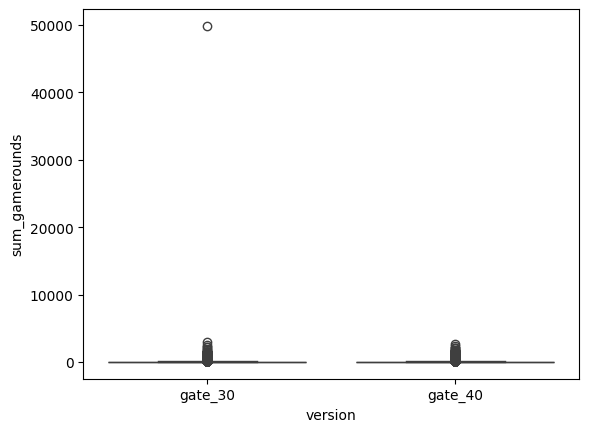

In [20]:
sns.boxplot(x = df.version, y = df.sum_gamerounds)
plt.show()

In [21]:
# let determine the low_limit and up_limit
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

outlier_thresholds(df,"sum_gamerounds")

(-739.5, 1232.5)

In [22]:
# Let's use the suppression method for outliers
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

replace_with_thresholds(df,"sum_gamerounds")

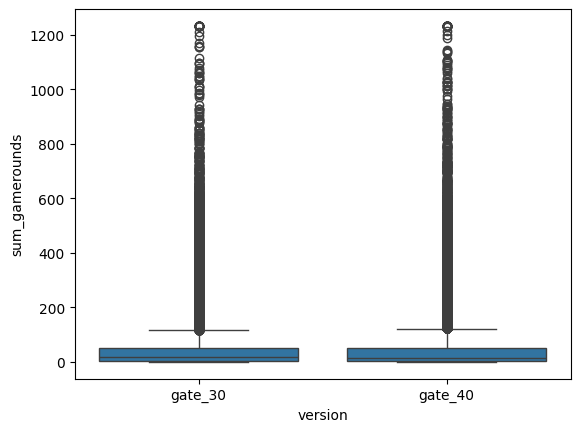

In [23]:
sns.boxplot(x = df.version, y = df.sum_gamerounds)
plt.show()

In [24]:
df.groupby("version").agg({"sum_gamerounds":"mean"})
# it seems similar but let's implement the A-B testing

,sum_gamerounds
version,
gate_30,51.1534
gate_40,51.0658


# A/B Testing

### Steps 

* first we will establish the hypothesis
* H0: M1 = M2 (no difference)
* H1: M1 != M2
* Then we will move on to the assumption checking phase.
* If normality assumption + variance assumption is met, we can test with paramedric t test
* If normality is achieved but variance is not achieved, we can retest with the t test, but we are gonna change equal_var to False 
* If the normality assumption is not met, we will directly apply the MannWhitneyu test (non-parametric test).

In [19]:
# Let's apply it one by one, then I will add the whole function

In [20]:
# 1. Establish Hypothesis:
# Is there a statistical difference between gate_30 and gate_40 playing games?
# Ho: M1=M2 (no difference between them)
# H1= M1!=M2 (there is a difference between them)

In [21]:
# 1. Normality

# H0: Normal distribution assumption is met.
# H1:..not provided.

# HO RED if p-value < 0.05.
# If p-value is not < 0.05 H0 CANNOT BE REJECTED.

In [25]:
test_stat, pvalue = shapiro(df.loc[df["version"] == "gate_30", "sum_gamerounds"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))
# p value less than 0.05

Test Stat = 0.5104, p-value = 0.0000


In [26]:
test_stat, pvalue = shapiro(df.loc[df["version"] == "gate_40", "sum_gamerounds"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))
# since p-value is less than 0.05 , we are gonna reject Ho , so  Normal distribution assumption is not provided.

Test Stat = 0.5044, p-value = 0.0000


In [27]:
# We can pass directly to mannwhitneyu test (non-parametric test)
test_stat, pvalue = mannwhitneyu(df.loc[df["version"] == "gate_30", "sum_gamerounds"],
                                 df.loc[df["version"] == "gate_40", "sum_gamerounds"])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue)) 

Test Stat = 1024331275.0000, p-value = 0.0502


p- value is not less than 0.05 , then H0 can not be rejected this means that there is no statistically significant difference between them

In [28]:
# Whole Function 

def a_b_test(df, p_value):
    
    print("H0:There is no statistical difference between gate_30 and gate_40.")
    print("##########################################")
    print("Normality Assumption")
    pvalue_30 = shapiro(df.loc[df["version"] == "gate_30", "sum_gamerounds"])[1]
    pvalue_40= shapiro(df.loc[df["version"] == "gate_40", "sum_gamerounds"])[1]

    if  (pvalue_30 < p_value) and (pvalue_40 < p_value):
        print("H0 is rejected, Normal distribution assumption is not met.\n")
    else:
        print("H0 cannot be rejected, normal distribution assumption is met.\n")
        
    print("##########################################")
    print(" Variance Homogeneity Assumption.\n")

    pvalue_levene = levene(df.loc[df["version"] == "gate_30", "sum_gamerounds"],
                               df.loc[df["version"] == "gate_40", "sum_gamerounds"])[1]

    if pvalue_levene < pvalue:
      print("H0 is rejected, the variances are not homogeneous\n")

    else:
       print(pvalue_levene,"Variances Are Homogeneous.\n")
    
    print("##########################################") 
    
    if ((pvalue_30 > pvalue) & (pvalue_40 > pvalue)) & (pvalue_levene > pvalue):
        
        pvalue_ttes = ttest_ind(df.loc[df["version"] == "gate_30"],
                                  df.loc[df["version"] == "gate_40"],
                                  equal_var=True)[1]
        print(pvalue_ttes)
    elif ((pvalue_30 > pvalue) & (pvalue_40 > pvalue)) & (pvalue_levene < pvalue):
        
        pvalue_ttest = ttest_ind(df.loc[df["version"] == "gate_30"],
                                  df.loc[df["version"] == "gate_40"],
                                  equal_var=False)[1]
        print(pvalue_ttes)
    else:
        print("Non-Parametric test should be done.\n")
        pvalue_non = mannwhitneyu(df.loc[df["version"] == "gate_30", "sum_gamerounds"],
                              df.loc[df["version"] == "gate_40", "sum_gamerounds"])[1]
        print(pvalue_non)
    print("################### Result #######################") 
    if pvalue_non < pvalue:
        print(pvalue_non,"H0 Hypothesis is Rejected. That is, there is a statistically significant difference between them.")
    else:
        print(pvalue_non, "is not less than 0.05 . H0 is Not Rejected, That is, there is no statistically significant difference between them.")
a_b_test(df, 0.05)

H0:There is no statistical difference between gate_30 and gate_40.
##########################################
Normality Assumption
H0 is rejected, Normal distribution assumption is not met.

##########################################
 Variance Homogeneity Assumption.

0.8301768432506422 Variances Are Homogeneous.

##########################################
Non-Parametric test should be done.

0.05020807227301571
################### Result #######################
0.05020807227301571 is not less than 0.05 . H0 is Not Rejected, That is, there is no statistically significant difference between them.
